In [1]:
%pylab inline
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
from IPython.display import clear_output
import time
#from time import sleep
import numpy as np
import math
import gym

Populating the interactive namespace from numpy and matplotlib


In [4]:
#from myfrozen import frozen_lake
import myfrozen

In [30]:
from gym.envs.registration import register, spec

MY_ENV_NAME='FrozenLakeNonskid8x8-v2'
register(
        id=MY_ENV_NAME,
        entry_point='myfrozen.frozen_lake:FrozenLakeEnv',
        kwargs={'map_name': '8x8', 'is_slippery': False},
        timestep_limit=100,
        reward_threshold=0.78, # optimum = .8196
)

env = gym.make(MY_ENV_NAME)

In [6]:
def to_onehot(size,value):
  my_onehot = np.zeros((size))
  my_onehot[value] = 1.0
  return my_onehot

OBSERVATION_SPACE = env.observation_space.n
ACTION_SPACE = env.action_space.n

# Assume gridworld is always square
OBS_SQR = int(math.sqrt(OBSERVATION_SPACE))
STATEGRID = np.zeros((OBS_SQR,OBS_SQR))

## Plotting 

In [56]:
def run_episode(env,Q,learning_rate,gamma,episode):
    observation = env.reset()
    done = False
    t_reward = 0
    max_steps = 100
    #max_steps = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')
    move_counter = 0
    for j in range(max_steps):
        if done:
            break

        curr_state = observation

        #action = np.argmax(Q[curr_state,:]  + np.random.randn(1, env.action_space.n)*(1./(episode+1)))
        action = np.argmax(Q[curr_state,:]  + np.random.randn(1, env.action_space.n))
        
        move_counter+=1
        
        observation, reward, done, info = env.step(action)

        t_reward += reward

        #Q(state, action) = R(state, action) + Gamma * Max[Q(next state, all actions)]
        Q[curr_state,action] += learning_rate * (reward+ gamma*np.max(Q[observation,:])-Q[curr_state,action])

    return Q, t_reward, done, move_counter

In [57]:
def trainer(epochs=1000,learning_rate = 0.81,discount = 0.96):
    #env = gym.make('FrozenLake-v0')
    #env = wrappers.Monitor(env, '/tmp/FrozenLake-experiment-6',force=True)

    reward_per_ep = list()
    wins = 0
    losses = 0
    #move_counter = 0
    #observation = env.reset()
    
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    for i in range(epochs):
        #print i
        Q, t_reward, done, move_counter = run_episode(env,Q,learning_rate,discount,i)
        #print done
        reward_per_ep.append(t_reward)

        if done:
            if t_reward > 0 : # Win
                wins += 1
            else: # Loss
                losses += 1
        time.sleep(.1)        
        clear_output(wait=True)
        print("Game #: %s" % (i+1,))
        print("Moves this round %s" % move_counter)
        print("Final Position:")
        env.render()
        print("Wins/Losses %s/%s" % (wins, losses))
    return Q, reward_per_ep

In [61]:
%%time
q, rpe = trainer(epochs=2000)

Game #: 2000
Moves this round 31
Final Position:
  (Right)
FFSFFFFF
FHFFFFFF
FFFHFFFF
FFFFFFFH
FFFFFFHF
FFFFHFFF
FFFHFFFF
GFFFFFFF
Wins/Losses 164/1836
CPU times: user 15 s, sys: 11.9 s, total: 26.9 s
Wall time: 3min 39s


In [62]:
q

array([[0.75144748, 0.78275779, 0.72138958, 0.75144748],
       [0.75144748, 0.        , 0.692534  , 0.72138958],
       [0.72138958, 0.72138958, 0.66483264, 0.692534  ],
       [0.692534  , 0.692534  , 0.63823933, 0.66483264],
       [0.66483264, 0.66483264, 0.61270976, 0.63823933],
       [0.63823933, 0.63823933, 0.58820137, 0.61270976],
       [0.61270976, 0.61270976, 0.56467331, 0.58820137],
       [0.58820137, 0.58820137, 0.56467331, 0.56467331],
       [0.78275779, 0.8153727 , 0.        , 0.75144748],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.75144748, 0.692534  , 0.692534  ],
       [0.72138958, 0.        , 0.66483264, 0.66483264],
       [0.692534  , 0.692534  , 0.63823933, 0.63823933],
       [0.66483264, 0.66483264, 0.61270976, 0.61270976],
       [0.63823933, 0.63823933, 0.58820137, 0.58820137],
       [0.61270976, 0.61270976, 0.58820137, 0.56467331],
       [0.8153727 , 0.84934656, 0.78275779, 0.78275779],
       [0.8153727 , 0.8153727 ,

### What the Value network has learned


FFSFFFFF
FHFFFFFF
FFFHFFFF
FFFFFFFH
FFFFFFHF
FFFFHFFF
FFFHFFFF
GFFFFFFF


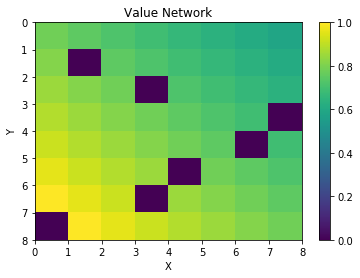

In [63]:
# Plot out the values the critic gives for the agent being in
# a specific state, i.e. in a specific location in the env.
def plot_value(initial_state):
    # Assume gridworld is always a square
    obs_sqr = math.sqrt(OBSERVATION_SPACE)
    np_w_cri_r = np.zeros((OBS_SQR,OBS_SQR))
    # make a working copy.
    working_state = initial_state.copy()
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            my_state = working_state.copy()
            # Place the player at a given X/Y location.
            my_state[x,y] = 1
            obs_predict = my_state.reshape(1,OBSERVATION_SPACE,)
            obs_predict = np.squeeze(obs_predict)
            index, = np.where(obs_predict == 1.)
            value = np.max(q[index,:])
            #value = 0
            np_w_cri_r[x,y] = value
    np_w_cri_r.shape
    pylab.pcolor(np_w_cri_r)
    pylab.title("Value Network")
    pylab.colorbar()
    pylab.xlabel("X")
    pylab.ylabel("Y")
    pylab.gca().invert_yaxis()
    pylab.draw()

env.reset()
env.render()
plot_value(STATEGRID)

### Showing Policy

In [64]:
A2A=['<','v','>','^']
def show_policy(initial_state):
    grid = np.zeros((OBS_SQR,OBS_SQR), dtype='<U2')
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            my_state = initial_state.copy()
            my_state[x,y] = 1

            obs_predict = my_state.reshape(1,OBSERVATION_SPACE,)
            obs_predict = np.squeeze(obs_predict)
            index, = np.where(obs_predict == 1.)
            action = np.argmax(q[index,:])
            grid[x,y] = A2A[action]
    grid
    return grid

env.reset()
env.render()
print(show_policy(STATEGRID))


FFSFFFFF
FHFFFFFF
FFFHFFFF
FFFFFFFH
FFFFFFHF
FFFFHFFF
FFFHFFFF
GFFFFFFF
[[u'v' u'<' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'v' u'<' u'v' u'<' u'<' u'<' u'<' u'<']
 [u'v' u'<' u'<' u'<' u'v' u'<' u'<' u'<']
 [u'v' u'<' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'v' u'<' u'<' u'<' u'<' u'<' u'<' u'v']
 [u'v' u'<' u'<' u'<' u'<' u'v' u'<' u'<']
 [u'v' u'<' u'<' u'<' u'v' u'v' u'v' u'<']
 [u'<' u'<' u'<' u'<' u'<' u'<' u'<' u'<']]


In [65]:
def play(render_every_step=False):
    observation = env.reset()
    done = False
    reward = 0.0
    max_moves = 50
    move_counter = 0
    while not done and move_counter < max_moves:
        state = to_onehot(OBSERVATION_SPACE,observation)
        #qval = actor_model.predict( state.reshape(1,OBSERVATION_SPACE) )
        obs_predict = state.reshape(1,OBSERVATION_SPACE,)
        obs_predict = np.squeeze(obs_predict)
        index, = np.where(obs_predict == 1.)
        action = np.argmax(q[index,:])
        #action = (np.argmax(qval))
        observation, reward, done, info = env.step(action)
        print(A2A[action])
        if render_every_step:
            env.render()
        move_counter += 1
    env.render()

In [66]:
play(render_every_step=True)

<
  (Left)
FFSFFFFF
FHFFFFFF
FFFHFFFF
FFFFFFFH
FFFFFFHF
FFFFHFFF
FFFHFFFF
GFFFFFFF
<
  (Left)
FFSFFFFF
FHFFFFFF
FFFHFFFF
FFFFFFFH
FFFFFFHF
FFFFHFFF
FFFHFFFF
GFFFFFFF
v
  (Down)
FFSFFFFF
FHFFFFFF
FFFHFFFF
FFFFFFFH
FFFFFFHF
FFFFHFFF
FFFHFFFF
GFFFFFFF
v
  (Down)
FFSFFFFF
FHFFFFFF
FFFHFFFF
FFFFFFFH
FFFFFFHF
FFFFHFFF
FFFHFFFF
GFFFFFFF
v
  (Down)
FFSFFFFF
FHFFFFFF
FFFHFFFF
FFFFFFFH
FFFFFFHF
FFFFHFFF
FFFHFFFF
GFFFFFFF
v
  (Down)
FFSFFFFF
FHFFFFFF
FFFHFFFF
FFFFFFFH
FFFFFFHF
FFFFHFFF
FFFHFFFF
GFFFFFFF
v
  (Down)
FFSFFFFF
FHFFFFFF
FFFHFFFF
FFFFFFFH
FFFFFFHF
FFFFHFFF
FFFHFFFF
GFFFFFFF
v
  (Down)
FFSFFFFF
FHFFFFFF
FFFHFFFF
FFFFFFFH
FFFFFFHF
FFFFHFFF
FFFHFFFF
GFFFFFFF
v
  (Down)
FFSFFFFF
FHFFFFFF
FFFHFFFF
FFFFFFFH
FFFFFFHF
FFFFHFFF
FFFHFFFF
GFFFFFFF
  (Down)
FFSFFFFF
FHFFFFFF
FFFHFFFF
FFFFFFFH
FFFFFFHF
FFFFHFFF
FFFHFFFF
GFFFFFFF
